# Single analyser of Model1 on single image using iNNvestigate

## Circular shapes with same radius

This notebook shows how saliency maps are computed for a single method on the Shape Images dataset.

(It is based on the **iNNvestigate** notebook: [Introduciton](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/introduction.ipynb))

## Imports

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import imp
import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

import innvestigate
import innvestigate.utils as iutils
mnistutils = imp.load_source("utils_mnist", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils_mnist.py")

from CNNcount import shape_images as si
from CNNcount import model_count_shapes as mcs


Using TensorFlow backend.


## Data
Load the dataset and keep some images from the test set for the analysis.

In [3]:
# filename for loading the data from the NPZ files (NumPy compressed)
same_shape_same_radius_fname = "/home/elena/eStep/XAI/Data/CountingShapes/circles_same_radius_60k.npz"
# input image dimensions and number of classes
img_rows, img_cols = 64, 64
num_classes = 3

# load the set of images with the same type and same radius and split to train and test subsets
if os.path.isfile(same_shape_same_radius_fname): # already generated- just load
    print ("The file containing images of the same shape (circle) with same radius already exist!")
    # load from NPZ file for display
    images_train, _, images_test, labels_train, _, labels_test = si.load_split_data(same_shape_same_radius_fname)
    
    
    if K.image_data_format() == 'channels_first':
        images_train = images_train.reshape(images_train.shape[0], 1, img_rows, img_cols)
        images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)

    print("Size of training data: ", np.shape(images_train), "and labels: ", np.shape(labels_train))
    print("Size of test data: ", np.shape(images_test), "and labels: ", np.shape(labels_test))
else: # missing data
    print ("The file containing images of the same shape (circle) with same radius does not exist!")
    print("Use the GenerateShapeImages notebook to generate the experimental data.") 
    
# plot random 12 of the train images
si.plot_12images(images_train, labels_train)

The file containing images of the same shape (circle) with same radius already exist!


MemoryError: 

## Model
The next part evaluates the pretrained CNN.

In [22]:
# imports
from CNNcount import model_count_shapes as mcs
# filename for model saving
same_shape_same_radius_model_fname = "/home/elena/eStep/XAI/Data/CountingShapes/model_circles_same_radius.h5"
# load the trained model
from keras.models import load_model
model = load_model(same_shape_same_radius_model_fname) 
print("Loaded model from disk")

Loaded model from disk


Formatting of the labels

In [23]:
# convert class vectors to binary class matrices
numerical_labels_test = labels_test
labels_test = np_utils.to_categorical(numerical_labels_test-1, num_classes=None)
print(labels_test)
print('labels_test shape:', labels_test.shape)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
labels_test shape: (6000, 3)


Evaluate on test images.

In [24]:
score = model.evaluate(images_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.00011350703237500663
Test accuracy: 1.0


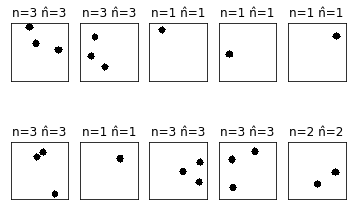

In [25]:
# generate 10 random images and predict the number of shapes using the trained model
for i in range(10):
    n = int(np.random.randint(1, 3+1))
    shapes = [(0, 4) for _ in range(n)]
    img = si.generate_image(64, shapes, 0)    
    
    X = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
    plt.subplot(2, 5, i+1)
    plt.imshow(img,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    predictions = model.predict(X);
    #print(predictions)
    pred = np.argmax(predictions) + 1 # we subtracted 1 before
    #print(pred)
    plt.title('n=%d n̂=%d' % (n, pred))

plt.show()

## Analysis

Chose a random test image to generate a heatmap for.

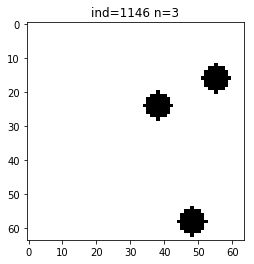

In [37]:
nim = len(labels_test)
ind=int(np.random.randint(1,nim))
img=images_test[ind,:,:]
img=np.reshape(img,(64,64))
label=numerical_labels_test[ind]
plt.imshow(img,cmap='binary')
plt.title('ind=%d n=%d' % (ind,label))
plt.show()

Create a gradient analyzer. It shows how the linearized network function reacts on changes of a single feature.
This is done by passing the model without a softmax to the analyzer class:

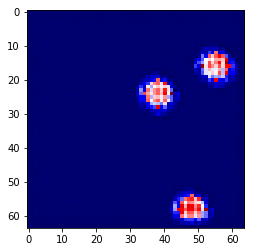

In [39]:
# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm)

# Applying the analyzer
image = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
analysis = gradient_analyzer.analyze(image)

# Displaying the gradient
plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plt.show()

## Choosing the class

Above the output of the neuron with the highest activation (the predicted class) is shown. Lets see the output in respect to the other classes.

Lets try another analyser from the *attribution* category - The gradient_input analyzer and visualize it by means of a colored heatmap to highlight positive and negative attributions:

Analysis w.r.t. to class 1


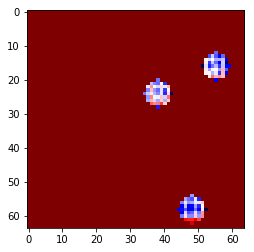

Analysis w.r.t. to class 2


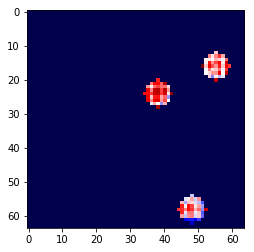

Analysis w.r.t. to class 3


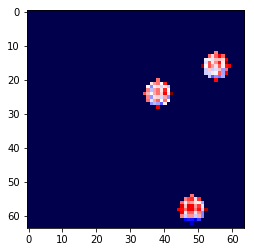

In [42]:
# Creating an analyzer and set neuron_selection_mode to "index"
inputXgradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model_wo_sm,
                                                       neuron_selection_mode="index")

for neuron_index in range(num_classes):
    print("Analysis w.r.t. to class", neuron_index+1)
    # Applying the analyzer and pass that we want 
    analysis = inputXgradient_analyzer.analyze(image, neuron_index)
    
    # Displaying the gradient
    plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
    plt.show()